## Lab 3. Detección de Malware

### Miembros
* Fernanda Esquivel - 21542
* Andrés Montoya - 21552

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Lab-04)

# Creación del dataset

In [2]:
import os
import pandas as pd
import numpy as np
import pefile
import hashlib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from datetime import datetime
warnings.filterwarnings('ignore')

In [3]:
# 1. Creación del dataset mediante análisis estático (enfocado)
def getFileHash(file_path):
    """Calcular el hash MD5 de un archivo."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [ ]:
def getPEFeatures(file_path):
    """Extraer características estáticas clave de un archivo PE."""
    features = {}
    
    # Metadatos básicos del archivo
    features['file_name'] = os.path.basename(file_path)
    features['file_size'] = os.path.getsize(file_path)
    features['md5'] = getFileHash(file_path)
    
    try:
        pe = pefile.PE(file_path)
        
        #Detección si el ejecutable está empaquetado
        #(Basado en características comunes de empaquetadores)
        is_packed = False
        packed_sections = ['UPX', '.aspack', '.packed', '.MPRESS', '.npack']
        
        # Verificar nombres de secciones sospechosas
        if hasattr(pe, 'sections'):
            for section in pe.sections:
                name = section.Name.decode('utf-8', 'ignore').strip('\x00')
                if any(packer in name for packer in packed_sections):
                    is_packed = True
                    break
        
        #Verificar alta entropía (común en binarios empaquetados)
        high_entropy_sections = 0
        for section in pe.sections:
            #Calcular entropía de la sección
            entropy = 0
            if len(section.get_data()) > 0:
                byte_counts = {}
                for byte in section.get_data():
                    if isinstance(byte, int):  # Para Python 3
                        byte_counts[byte] = byte_counts.get(byte, 0) + 1
                    else:  # Para Python 2
                        byte_counts[ord(byte)] = byte_counts.get(ord(byte), 0) + 1
                
                for count in byte_counts.values():
                    probability = float(count) / len(section.get_data())
                    entropy -= probability * np.log2(probability)
                    
                if entropy > 7.0:  # Umbral de alta entropía
                    high_entropy_sections += 1
        
        if high_entropy_sections >= 2:
            is_packed = True
            
        #Si hay pocos imports es sospechoso de empaquetamiento
        few_imports = False
        if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
            total_imports = sum(len(entry.imports) for entry in pe.DIRECTORY_ENTRY_IMPORT)
            if total_imports < 10:  # Umbral arbitrario para pocos imports
                few_imports = True
                
        if few_imports:
            is_packed = True
            
        features['is_packed'] = 1 if is_packed else 0
        
        #Secciones
        section_names = []
        section_entropies = []
        
        if hasattr(pe, 'sections'):
            for section in pe.sections:
                name = section.Name.decode('utf-8', 'ignore').strip('\x00')
                section_names.append(name)
                
                #Calcular entropía de la sección
                entropy = 0
                if len(section.get_data()) > 0:
                    byte_counts = {}
                    for byte in section.get_data():
                        if isinstance(byte, int):  # Para Python 3
                            byte_counts[byte] = byte_counts.get(byte, 0) + 1
                        else:  # Para Python 2
                            byte_counts[ord(byte)] = byte_counts.get(ord(byte), 0) + 1
                    
                    for count in byte_counts.values():
                        probability = float(count) / len(section.get_data())
                        entropy -= probability * np.log2(probability)
                
                section_entropies.append(entropy)
        
        features['section_names'] = '|'.join(section_names)
        features['number_of_sections'] = len(section_names)
        
        #DLLs y funciones utilizadas
        imported_dlls = []
        imported_functions_count = 0
        
        if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
            for entry in pe.DIRECTORY_ENTRY_IMPORT:
                dll_name = entry.dll.decode('utf-8', 'ignore')
                imported_dlls.append(dll_name.lower())
                imported_functions_count += len(entry.imports)
        
        features['imported_dlls'] = '|'.join(imported_dlls)
        features['imported_dlls_count'] = len(imported_dlls)
        features['imported_functions_count'] = imported_functions_count
        
        #Detección de DLLs sospechosas
        suspicious_dlls = ['ws2_32.dll', 'wininet.dll', 'urlmon.dll', 'shell32.dll', 'advapi32.dll']
        suspicious_dll_count = sum(1 for dll in imported_dlls if dll.lower() in suspicious_dlls)
        features['suspicious_dll_count'] = suspicious_dll_count
        
        #Fecha de compilación
        if hasattr(pe, 'FILE_HEADER'):
            timestamp = pe.FILE_HEADER.TimeDateStamp
            try:
                compile_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
                features['compile_date'] = compile_date
                
                #Antigüedad del ejecutable (en días desde la fecha actual)
                days_since_compile = (datetime.now() - datetime.fromtimestamp(timestamp)).days
                features['days_since_compile'] = days_since_compile
            except:
                #Los timestamps son inválidos
                features['compile_date'] = 'Invalid'
                features['days_since_compile'] = -1
        
        #Entropía general del archivo
        if hasattr(pe, 'sections'):
            # Entropía promedio de todas las secciones
            features['avg_entropy'] = np.mean(section_entropies) if section_entropies else 0
            features['max_entropy'] = max(section_entropies) if section_entropies else 0
        
        #Características adicionales
        #Tipo de archivo
        features['is_dll'] = 1 if pe.is_dll() else 0
        features['is_exe'] = 1 if pe.is_exe() else 0
        
        #Arquitectura
        features['is_32bit'] = 1 if pe.FILE_HEADER.Machine == 0x14c else 0
        features['is_64bit'] = 1 if pe.FILE_HEADER.Machine == 0x8664 else 0
        
        #Liberar recursos
        pe.close()
    
    except Exception as e:
        #Si hay algún error, devolver características básicas solamente
        features['parse_error'] = str(e)
        features['is_packed'] = -1  # Desconocido
        features['number_of_sections'] = -1
        features['imported_dlls_count'] = -1
        features['imported_functions_count'] = -1
        features['compile_date'] = 'Unknown'
        features['days_since_compile'] = -1
        features['avg_entropy'] = -1
        features['max_entropy'] = -1
        features['is_dll'] = -1
        features['is_exe'] = -1
        features['is_32bit'] = -1
        features['is_64bit'] = -1
        features['suspicious_dll_count'] = -1
    
    return features

In [ ]:
def createMalwareDataset(malware_directory):
    """Crear un dataset a partir de archivos de malware en un directorio."""
    data = []
    files = []
    
    #Obtener todos los archivos en el directorio recursivamente
    for root, dirs, filenames in os.walk(malware_directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    
    print(f"Encontrados {len(files)} archivos para analizar.")
    
    #Procesar cada archivo
    for i, file_path in enumerate(files):
        try:
            features = getPEFeatures(file_path)
            data.append(features)
            if (i + 1) % 100 == 0:
                print(f"Procesados {i + 1} archivos...")
        except Exception as e:
            print(f"Error en archivo {file_path}: {str(e)}")
    
    #Crear DataFrame
    df = pd.DataFrame(data)
    return df

In [ ]:
malware_directory = "malwr/MALWR"

#Crear el dataset
df = createMalwareDataset(malware_directory)
print(f"Dataset creado con {df.shape[0]} filas y {df.shape[1]} columnas.")

#Guardar el dataset bruto
df.to_csv("datasets/malware_dataset_raw.csv", index=False)
print("Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'")

Encontrados 41 archivos para analizar.
Dataset creado con 41 filas y 19 columnas.
Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'


# Exploración y pre-procesamiento de datos

## Carga del dataset

In [83]:
df = pd.read_csv('datasets/malware_dataset_raw.csv')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset cargado con 41 filas y 19 columnas.


In [84]:
#Eliminar la primera fila
df = df.iloc[1:].reset_index(drop=True)
print(f"Dataset después de eliminar la primera fila: {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset después de eliminar la primera fila: 40 filas y 19 columnas.


## Exploración básica del dataset

In [85]:
print("\nInformación básica del dataset:")
print(df.info())


Información básica del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   file_name                 40 non-null     object 
 1   file_size                 40 non-null     int64  
 2   md5                       40 non-null     object 
 3   parse_error               0 non-null      object 
 4   is_packed                 40 non-null     int64  
 5   number_of_sections        40 non-null     int64  
 6   imported_dlls_count       40 non-null     int64  
 7   imported_functions_count  40 non-null     int64  
 8   compile_date              40 non-null     object 
 9   days_since_compile        40 non-null     int64  
 10  avg_entropy               40 non-null     float64
 11  max_entropy               40 non-null     float64
 12  is_dll                    40 non-null     int64  
 13  is_exe                    40 non-n

In [86]:
print("\nEstadísticas descriptivas para columnas numéricas:")
print(df.describe())


Estadísticas descriptivas para columnas numéricas:
          file_size  is_packed  number_of_sections  imported_dlls_count  \
count      40.00000  40.000000           40.000000            40.000000   
mean    72217.60000   0.800000            3.025000             5.875000   
std    129008.10712   0.405096            0.158114             1.522271   
min      5120.00000   0.000000            3.000000             4.000000   
25%      5632.00000   1.000000            3.000000             5.000000   
50%      5632.00000   1.000000            3.000000             5.000000   
75%     15360.00000   1.000000            3.000000             7.000000   
max    348160.00000   1.000000            4.000000             9.000000   

       imported_functions_count  days_since_compile  avg_entropy  max_entropy  \
count                 40.000000           40.000000    40.000000    40.000000   
mean                  23.775000         5473.100000     3.767030     7.335515   
std                   31.0272

In [87]:
#Verificar valores nulos
print("\nValores nulos por columna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Valores nulos por columna:
parse_error    40
dtype: int64


## Visualizaciones básicas

Text(0, 0.5, '')

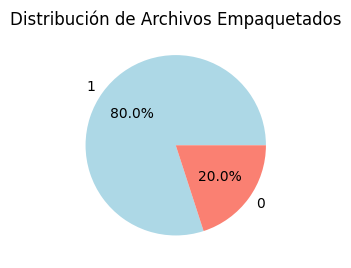

In [88]:
plt.subplot(1, 2, 1)
df['is_packed'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Distribución de Archivos Empaquetados')
plt.ylabel('')

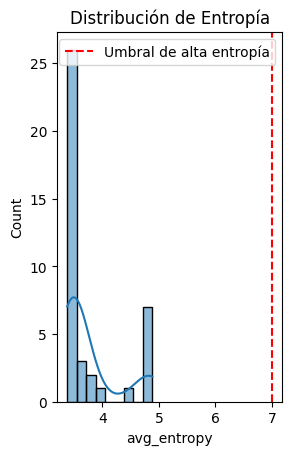

In [89]:
plt.subplot(1, 2, 2)
sns.histplot(df['avg_entropy'].dropna(), kde=True)
plt.axvline(x=7.0, color='r', linestyle='--', label='Umbral de alta entropía')
plt.title('Distribución de Entropía')
plt.legend()

## Preprocesamiento

In [90]:
#Seleccionar solo características numéricas
numerical_features = ['file_size', 'is_packed', 'number_of_sections', 'imported_dlls_count', 
                    'imported_functions_count', 'days_since_compile', 'avg_entropy', 
                    'max_entropy', 'is_dll', 'is_exe', 'suspicious_dll_count']

In [91]:
#Manejar valores faltantes con la mediana
df_clean = df[numerical_features].copy()
df_clean = df_clean.fillna(df_clean.median())

In [92]:
print(f"Dataset limpio con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")
print("Columnas seleccionadas:", numerical_features)

Dataset limpio con 40 filas y 11 columnas.
Columnas seleccionadas: ['file_size', 'is_packed', 'number_of_sections', 'imported_dlls_count', 'imported_functions_count', 'days_since_compile', 'avg_entropy', 'max_entropy', 'is_dll', 'is_exe', 'suspicious_dll_count']


In [93]:
#Normalización/Estandarización
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_clean),
    columns=df_clean.columns
)

In [94]:
print("Dataset escalado (primeras 5 filas):")
print(df_scaled.head())

Dataset escalado (primeras 5 filas):
   file_size  is_packed  number_of_sections  imported_dlls_count  \
0   -0.52673        0.5           -0.160128            -1.247404   
1   -0.52271        0.5           -0.160128            -0.582122   
2   -0.52271        0.5           -0.160128            -0.582122   
3   -0.52271        0.5           -0.160128            -0.582122   
4   -0.52271        0.5           -0.160128            -0.582122   

   imported_functions_count  days_since_compile  avg_entropy  max_entropy  \
0                 -0.547541            0.143512    -0.737762     0.397637   
1                 -0.514901            2.133516    -0.495134     0.342715   
2                 -0.514901            2.133516    -0.496089     0.340109   
3                 -0.514901            0.763970    -0.492902     0.348808   
4                 -0.514901            0.763970    -0.491575     0.352430   

     is_dll    is_exe  suspicious_dll_count  
0 -0.377964  0.377964             -1.401826  

In [95]:
df_clean.to_csv('datasets/malware_dataset_clean.csv', index=False)

In [96]:
print("\nPreprocesamiento completado. Dataset guardado:")
print("* malware_dataset_clean.csv: Dataset limpio con características numéricas")


Preprocesamiento completado. Dataset guardado:
* malware_dataset_clean.csv: Dataset limpio con características numéricas


# Implementación del modelo

In [97]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm

In [98]:
#Carga del dataset limpio
df_clean = pd.read_csv('datasets/malware_dataset_clean.csv')
print(f"Dataset cargado con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas")

Dataset cargado con 40 filas y 11 columnas


In [99]:
#Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)
X_df = pd.DataFrame(X_scaled, columns=df_clean.columns)

## Funciones

In [100]:
#Función para visualizar el método del codo
def plotElbowMethod(X, max_k=10, title="Método del Codo para K-means"):
    inertias = []
    K_range = range(1, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    return inertias

In [101]:
#Función para calcular y visualizar el coeficiente de Silhouette
def plotSilhouetteScores(X, max_k=10, title="Coeficiente de Silhouette para K-means"):
    silhouette_avg_kmeans = []
    silhouette_avg_agg = []
    K_range = range(2, max_k + 1)  # Silhouette no está definido para k=1
    
    for k in K_range:
        # K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(X)
        silhouette_avg_kmeans.append(silhouette_score(X, kmeans_labels))
        
        # Agglomerative Clustering
        agg = AgglomerativeClustering(n_clusters=k)
        agg_labels = agg.fit_predict(X)
        silhouette_avg_agg.append(silhouette_score(X, agg_labels))
    
    plt.figure(figsize=(12, 6))
    plt.plot(K_range, silhouette_avg_kmeans, 'bo-', label='K-means')
    plt.plot(K_range, silhouette_avg_agg, 'ro-', label='Agglomerative')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Coeficiente de Silhouette')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return silhouette_avg_kmeans, silhouette_avg_agg

In [102]:
#Función para visualizar la silueta detallada para un k específico
def plotSilhouetteAnalysis(X, k):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(X)
    silhouette_avg_kmeans = silhouette_score(X, cluster_labels_kmeans)
    sample_silhouette_values_kmeans = silhouette_samples(X, cluster_labels_kmeans)
    
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=k)
    cluster_labels_agg = agg.fit_predict(X)
    silhouette_avg_agg = silhouette_score(X, cluster_labels_agg)
    sample_silhouette_values_agg = silhouette_samples(X, cluster_labels_agg)
    
    # Plot K-means silhouette
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values_kmeans[cluster_labels_kmeans == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title(f"Análisis de Silhouette para K-means (k={k})")
    ax1.set_xlabel("Coeficiente de Silhouette")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=silhouette_avg_kmeans, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    
    # Plot Agglomerative silhouette
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values_agg[cluster_labels_agg == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax2.set_title(f"Análisis de Silhouette para Agglomerative (k={k})")
    ax2.set_xlabel("Coeficiente de Silhouette")
    ax2.set_ylabel("Etiqueta del Cluster")
    ax2.axvline(x=silhouette_avg_agg, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xlim([-0.1, 1])
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg_kmeans, silhouette_avg_agg

In [103]:
#Función para visualizar el dendrograma (para Agglomerative Clustering)
def plotDendrogram(X, max_d=None):
    # Crear un dendrograma
    linked = linkage(X, 'ward')
    
    plt.figure(figsize=(12, 8))
    dendrogram(linked,
                orientation='top',
                distance_sort='descending',
                show_leaf_counts=True,
                truncate_mode='level', 
                p=5)
    
    if max_d:
        plt.axhline(y=max_d, c='k', linestyle='--', label=f'Distancia de corte = {max_d}')
        plt.legend()
    
    plt.title('Dendrograma Jerárquico')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')
    plt.show()

In [104]:
#Función para visualizar resultados de clustering
def plotClusteringResults(X, k_kmeans, k_agg):
    # Crear nuevos modelos con los k óptimos
    kmeans = KMeans(n_clusters=k_kmeans, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    
    agg = AgglomerativeClustering(n_clusters=k_agg)
    agg_labels = agg.fit_predict(X)
    
    # Aplicar PCA para visualizar en 2D
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Visualizar resultados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # K-means
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.8)
    ax1.set_title(f'Clusters K-means (k={k_kmeans})')
    ax1.set_xlabel('Componente Principal 1')
    ax1.set_ylabel('Componente Principal 2')
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
    ax1.add_artist(legend1)
    
    # Agglomerative
    scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', s=50, alpha=0.8)
    ax2.set_title(f'Clusters Agglomerative (k={k_agg})')
    ax2.set_xlabel('Componente Principal 1')
    ax2.set_ylabel('Componente Principal 2')
    legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
    ax2.add_artist(legend2)
    
    plt.tight_layout()
    plt.show()
    
    return kmeans_labels, agg_labels

## Método del codo


Aplicación del método del codo para K-means:


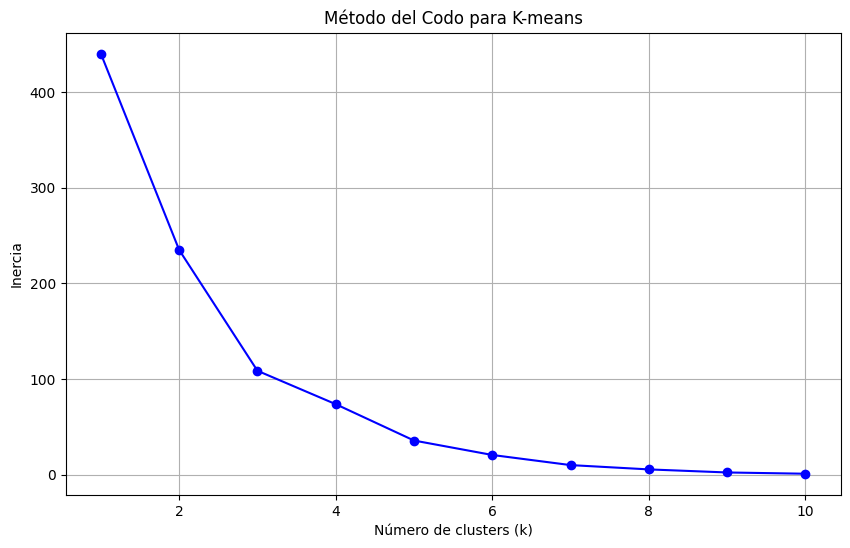

In [105]:
#Aplicar el método del codo para K-means
print("\nAplicación del método del codo para K-means:")
inertias = plotElbowMethod(X_scaled, max_k=10)


Calculo del coeficiente de Silhouette para K-means y Agglomerative Clustering:


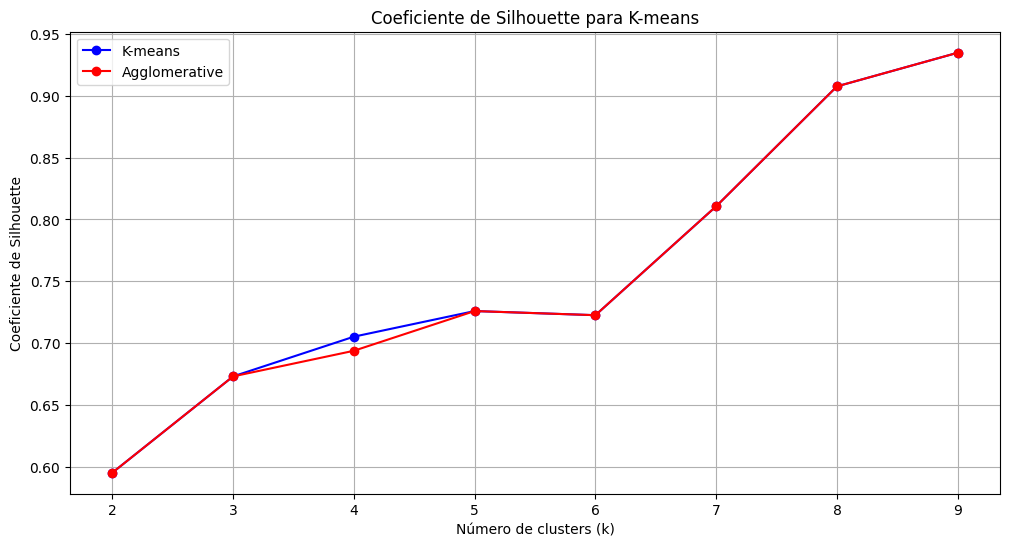

In [106]:
#Calcular y visualizar el coeficiente de Silhouette para ambos algoritmos
print("\nCalculo del coeficiente de Silhouette para K-means y Agglomerative Clustering:")
silhouette_avg_kmeans, silhouette_avg_agg = plotSilhouetteScores(X_scaled, max_k=9)

In [107]:
# Encontrar el k óptimo basado en Silhouette
k_optimal_kmeans = np.argmax(silhouette_avg_kmeans) + 2  # +2 porque el rango de k empieza en 2
k_optimal_agg = np.argmax(silhouette_avg_agg) + 2

In [108]:
print(f"\nK óptimo para K-means según Silhouette: {k_optimal_kmeans}")
print(f"K óptimo para Agglomerative según Silhouette: {k_optimal_agg}")


K óptimo para K-means según Silhouette: 9
K óptimo para Agglomerative según Silhouette: 9


## Dendograma


Visualización del dendrograma para Agglomerative Clustering:


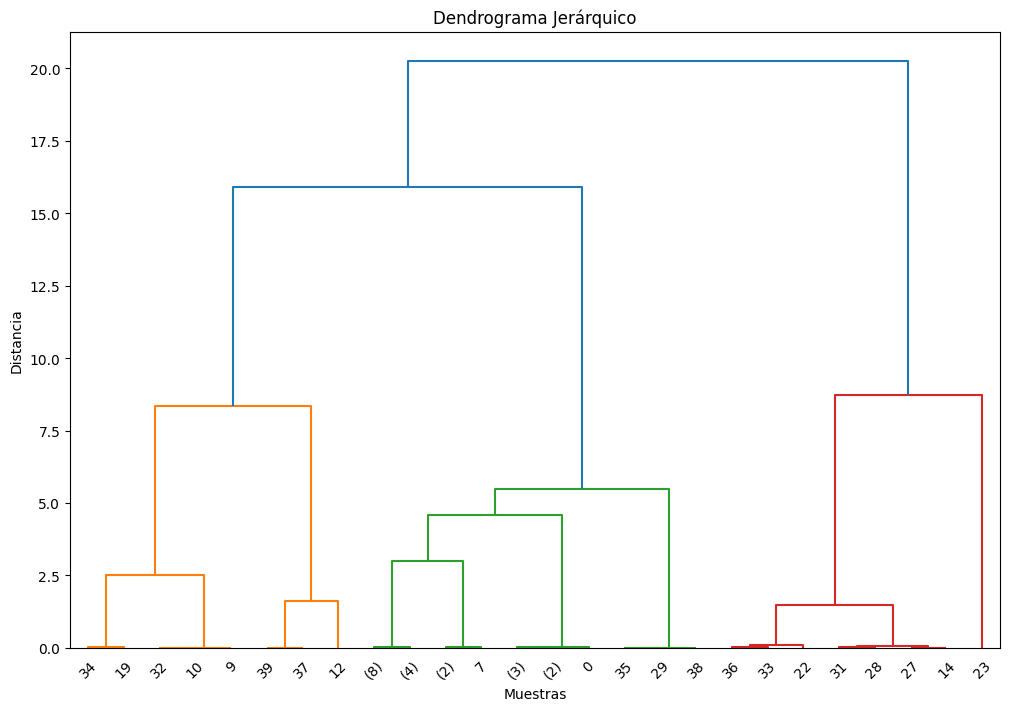

In [109]:
print("\nVisualización del dendrograma para Agglomerative Clustering:")
plotDendrogram(X_scaled)

## Análisis de Silhouette para los k óptimos


Análisis detallado de Silhouette para los k óptimos:


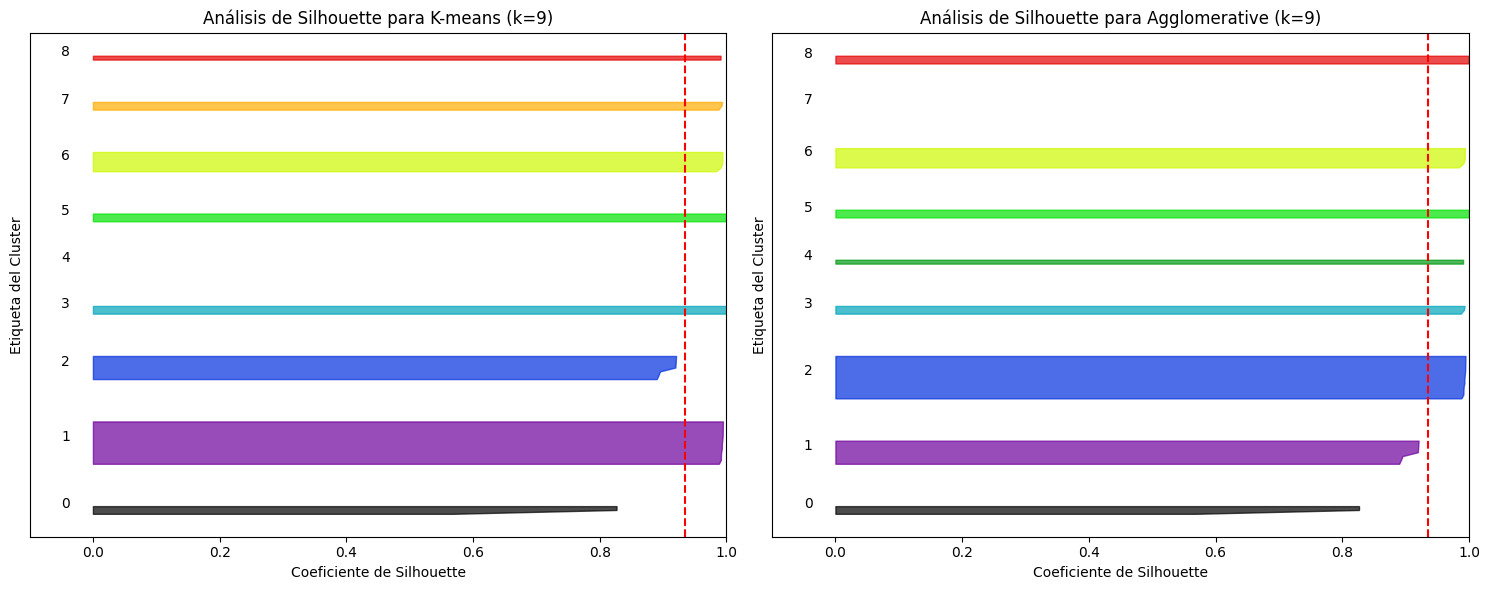

Coeficiente de Silhouette para K-means (k=9): 0.9346
Coeficiente de Silhouette para Agglomerative (k=9): 0.9346


In [110]:
print("\nAnálisis detallado de Silhouette para los k óptimos:")
sil_kmeans, sil_agg = plotSilhouetteAnalysis(X_scaled, k_optimal_kmeans)
print(f"Coeficiente de Silhouette para K-means (k={k_optimal_kmeans}): {sil_kmeans:.4f}")
print(f"Coeficiente de Silhouette para Agglomerative (k={k_optimal_agg}): {sil_agg:.4f}")

## Clustering


Visualición de resultados de clustering:


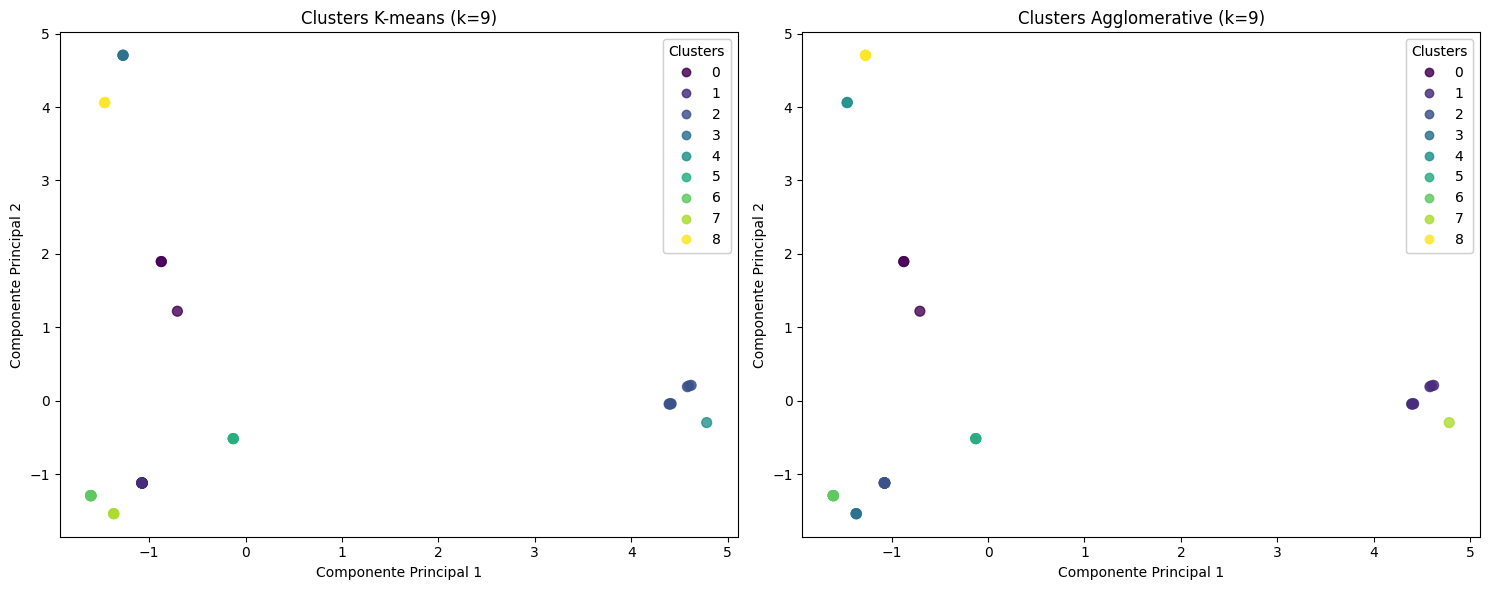

In [111]:
print("\nVisualición de resultados de clustering:")
kmeans_labels, agg_labels = plotClusteringResults(X_scaled, k_optimal_kmeans, k_optimal_agg)

In [112]:
#Agregar etiquetas de cluster al dataset original
df_results = df_clean.copy()
df_results['kmeans_cluster'] = kmeans_labels
df_results['agg_cluster'] = agg_labels

In [113]:
#Guardar resultados
df_results.to_csv('datasets/malware_clustering_results.csv', index=False)
print("\nResultados guardados en 'datasets/malware_clustering_results.csv'")


Resultados guardados en 'datasets/malware_clustering_results.csv'


In [114]:
#Análisis de características por cluster
print("\nAnálisis de características por cluster")

# Para K-means
print("Análisis de clusters K-means:")
kmeans_cluster_analysis = df_results.groupby('kmeans_cluster').agg({
    'file_size': 'mean',
    'is_packed': 'mean',
    'number_of_sections': 'mean',
    'imported_dlls_count': 'mean',
    'imported_functions_count': 'mean',
    'avg_entropy': 'mean',
    'max_entropy': 'mean',
    'is_dll': 'sum',
    'is_exe': 'sum',
    'suspicious_dll_count': 'mean',
    'file_size': 'count'  # Conteo de archivos por cluster
}).rename(columns={'file_size': 'count'})

print(kmeans_cluster_analysis)


Análisis de características por cluster
Análisis de clusters K-means:
                count  is_packed  number_of_sections  imported_dlls_count  \
kmeans_cluster                                                              
0                   3        1.0                 3.0             8.666667   
1                  12        1.0                 3.0             5.000000   
2                   7        0.0                 3.0             7.000000   
3                   3        1.0                 3.0             8.000000   
4                   1        0.0                 4.0             6.000000   
5                   3        1.0                 3.0             5.000000   
6                   6        1.0                 3.0             4.000000   
7                   3        1.0                 3.0             5.000000   
8                   2        1.0                 3.0             8.000000   

                imported_functions_count  avg_entropy  max_entropy  is_dll  \
kme

In [115]:
#Para Agglomerative
print("\nAnálisis de clusters Agglomerative:")
agg_cluster_analysis = df_results.groupby('agg_cluster').agg({
    'file_size': 'mean',
    'is_packed': 'mean',
    'number_of_sections': 'mean',
    'imported_dlls_count': 'mean',
    'imported_functions_count': 'mean',
    'avg_entropy': 'mean',
    'max_entropy': 'mean',
    'is_dll': 'sum',
    'is_exe': 'sum',
    'suspicious_dll_count': 'mean',
    'file_size': 'count'  # Conteo de archivos por cluster
}).rename(columns={'file_size': 'count'})

print(agg_cluster_analysis)


Análisis de clusters Agglomerative:
             count  is_packed  number_of_sections  imported_dlls_count  \
agg_cluster                                                              
0                3        1.0                 3.0             8.666667   
1                7        0.0                 3.0             7.000000   
2               12        1.0                 3.0             5.000000   
3                3        1.0                 3.0             5.000000   
4                2        1.0                 3.0             8.000000   
5                3        1.0                 3.0             5.000000   
6                6        1.0                 3.0             4.000000   
7                1        0.0                 4.0             6.000000   
8                3        1.0                 3.0             8.000000   

             imported_functions_count  avg_entropy  max_entropy  is_dll  \
agg_cluster                                                              

## Comparación de los algoritmos

In [116]:
#Matriz de confusión entre los dos algoritmos
print("\nComparación entre clasificaciones de K-means y Agglomerative:")
confusion_matrix = pd.crosstab(df_results['kmeans_cluster'], df_results['agg_cluster'], 
                                rownames=['K-means'], colnames=['Agglomerative'])
print(confusion_matrix)


Comparación entre clasificaciones de K-means y Agglomerative:
Agglomerative  0  1   2  3  4  5  6  7  8
K-means                                  
0              3  0   0  0  0  0  0  0  0
1              0  0  12  0  0  0  0  0  0
2              0  7   0  0  0  0  0  0  0
3              0  0   0  0  0  0  0  0  3
4              0  0   0  0  0  0  0  1  0
5              0  0   0  0  0  3  0  0  0
6              0  0   0  0  0  0  6  0  0
7              0  0   0  3  0  0  0  0  0
8              0  0   0  0  2  0  0  0  0


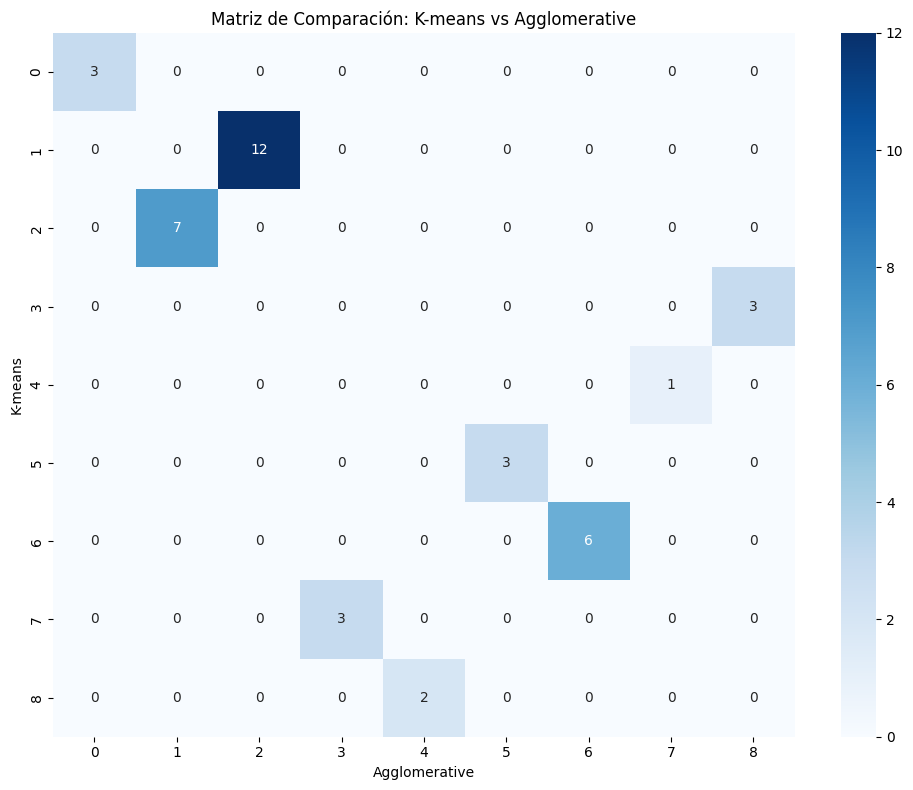

In [117]:
#Heatmap de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Comparación: K-means vs Agglomerative')
plt.tight_layout()
plt.show()

In [118]:
#Análisis de la diferencia en asignación de clusters
print("\nAnálisis de diferencia en asignación de clusters:")
df_results['same_cluster'] = df_results['kmeans_cluster'] == df_results['agg_cluster']
agreement_percentage = df_results['same_cluster'].mean() * 100
print(f"Porcentaje de acuerdo entre K-means y Agglomerative: {agreement_percentage:.2f}%")


Análisis de diferencia en asignación de clusters:
Porcentaje de acuerdo entre K-means y Agglomerative: 30.00%


In [119]:
#Características de muestras que difieren en la asignación de clusters
different_samples = df_results[~df_results['same_cluster']]
if len(different_samples) > 0:
    print(f"\nCaracterísticas promedio de muestras con diferente asignación ({len(different_samples)} muestras):")
    print(different_samples[numerical_features].mean())
    
    print("\nCaracterísticas promedio de muestras con la misma asignación:")
    print(df_results[df_results['same_cluster']][numerical_features].mean())


Características promedio de muestras con diferente asignación (28 muestras):
file_size                   65481.142857
is_packed                       0.714286
number_of_sections              3.035714
imported_dlls_count             6.071429
imported_functions_count       30.357143
days_since_compile           5531.464286
avg_entropy                     3.904153
max_entropy                     7.226887
is_dll                          0.178571
is_exe                          0.821429
suspicious_dll_count            2.535714
dtype: float64

Características promedio de muestras con la misma asignación:
file_size                   87936.000000
is_packed                       1.000000
number_of_sections              3.000000
imported_dlls_count             5.416667
imported_functions_count        8.416667
days_since_compile           5336.916667
avg_entropy                     3.447074
max_entropy                     7.588981
is_dll                          0.000000
is_exe                  